In [1]:
!nvidia-smi

Fri Mar 27 18:42:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro P5000        On   | 00000000:00:05.0 Off |                  Off |
| 26%   33C    P8     6W / 180W |      1MiB / 16278MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Install & import dependencies

In [2]:
!pip install torchtext --upgrade > /dev/null 2>&1
!python -m spacy download fr > /dev/null 2>&1
!python -m spacy download en > /dev/null 2>&1

In [3]:
import os
import re
import tqdm
import random
import unicodedata
import numpy as np
import matplotlib.pyplot as plt

import spacy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Example, Field, Dataset
from torchtext.data.iterator import BucketIterator
from torchtext.data.metrics import bleu_score

In [4]:
seed = 781
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


# Download data

In [5]:
if not os.path.exists('./data'):
    !mkdir ./data

In [6]:
%%time
!wget --no-check-certificate \
    http://www.statmt.org/europarl/v7/fr-en.tgz \
    -O ./data/fr-en.tgz

--2020-03-27 11:37:53--  http://www.statmt.org/europarl/v7/fr-en.tgz
Resolving www.statmt.org (www.statmt.org)... 129.215.197.184
Connecting to www.statmt.org (www.statmt.org)|129.215.197.184|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 202718517 (193M) [application/x-gzip]
Saving to: ‘./data/fr-en.tgz’

./data/fr-en.tgz    100%[===================>] 193.33M   123KB/s    in 40m 6s  

2020-03-27 12:18:00 (82.3 KB/s) - ‘./data/fr-en.tgz’ saved [202718517/202718517]

CPU times: user 42.3 s, sys: 13.9 s, total: 56.2 s
Wall time: 40min 7s


In [7]:
%%time
!tar -xzvf ./data/fr-en.tgz -C ./data

europarl-v7.fr-en.en
europarl-v7.fr-en.fr
CPU times: user 59.7 ms, sys: 27.2 ms, total: 86.9 ms
Wall time: 5.16 s


# Data processing

In [6]:
def read_file(filepath):
    try:
        with open(filepath, mode='rt', encoding='utf-8') as file:
            content = file.readlines()
        return content
    except:
        raise NotImplementedError(f'File {filepath} doesn\'t exist')

In [7]:
def unicode_to_ascii(s):
    # NFD => Normal Form Decompose
    # Mn => Non Marking Space
    return ''.join(c for c in unicodedata.normalize('NFD', s) \
                    if unicodedata.category(c) != 'Mn')

def normalize_string(s):
    # Transform accented characters into unaccented ones
    s = unicode_to_ascii(s.strip())
    # Remove a sequence of whitespace characters
    s = re.sub(r'\s+', r' ', s)
    return s.strip()

In [8]:
%%time
pairs = [*zip(read_file('./data/europarl-v7.fr-en.fr'),
              read_file('./data/europarl-v7.fr-en.en'))]
pairs = [*map(lambda x: {'fr': x[0], 'en': x[1]}, pairs)]
print(f'Number of examples: {len(pairs):,}')

Number of examples: 2,007,723
CPU times: user 3.59 s, sys: 1.06 s, total: 4.65 s
Wall time: 4.63 s


I do not build models the entire dataset, since is very large. Instead, I sample a subset of 30,000 sentence pairs.

In [9]:
%%time
pairs = np.random.choice(pairs, size=30000, replace=False)
pairs = [*map(lambda pair: {k: normalize_string(v) for k, v in pair.items()},
              pairs)]
print(f'Number of examples after sampling: {len(pairs):,}')
print(f'Example:\n\tFR => {pairs[0]["fr"]}\n\tEN => {pairs[0]["en"]}')

Number of examples after sampling: 30,000
Example:
	FR => Les procedures par le biais desquelles de tels produits entrent et sortent de l'Union europeenne doivent etre ouvertes, transparentes et, par dessus tout, sures.
	EN => The procedures whereby such products come in and out of the European Union have to be open, transparent and, above all, safe.
CPU times: user 4.03 s, sys: 95.7 ms, total: 4.12 s
Wall time: 4.12 s


Now, we split data in train, valid and test sets.

In [10]:
FR = Field(init_token='<sos>',
           eos_token='<eos>',
           preprocessing=lambda x: x[::-1],
           lower=True,
           tokenize='spacy',
           tokenizer_language='fr',
           include_lengths=True) # For pack_padded_sequence
EN = Field(init_token='<sos>',
           eos_token='<eos>',
           lower=True,
           tokenize='spacy',
           tokenizer_language='en')

examples = [Example.fromdict(data=pair, fields={'fr': ('src', FR),
                                                'en': ('dest', EN)})
            for pair in tqdm.tqdm(pairs)]
data = Dataset(examples, fields={'src': FR, 'dest': EN})

100%|██████████| 30000/30000 [00:42<00:00, 699.33it/s]


In [11]:
train_data, valid_data, test_data = data.split(split_ratio=[0.9, 0.05, 0.05])
print(f'train size: {len(train_data.examples)}')
print(f'valid size: {len(valid_data.examples)}')
print(f'test size: {len(test_data.examples)}')
print(vars(train_data.examples[0]))

train size: 27000
valid size: 1500
test size: 1500
{'src': ['.', 'europeenne', 'communaute', 'la', 'de', 'niveau', 'au', 'micro-gestion', 'une', 'a', 'proceder', 'de', 'tentation', 'la', 'a', 'resister', 'de', 'que', 'ainsi', ',', 'terrain', 'de', 'acteurs', 'les', 'par', 'fournies', 'etre', 'peuvent', 'qui', 'competences', 'des', 'et', 'connaissances', 'des', 'ampleur', "l'", 'reconnaitre', 'de', 'important', 'est', 'il', 'et', ',', 'propre', 'specificite', 'sa', 'possede', 'europeennes', 'mers', 'des', 'chacune'], 'dest': ['each', 'of', 'the', 'seas', 'in', 'europe', 'has', 'its', 'own', 'specificity', ',', 'and', 'it', 'is', 'important', 'to', 'recognise', 'the', 'level', 'of', 'knowledge', 'and', 'expertise', 'that', 'can', 'be', 'provided', 'by', 'the', 'stakeholders', 'on', 'the', 'ground', 'and', 'to', 'resist', 'the', 'temptation', 'to', 'micro', '-', 'manage', 'on', 'an', 'eu', 'level', '.']}


Since the model understands only number, we need to transform text sequences into sequence of numbers where each numbers represents a unique token. To do this, we build a vocabulary for each language that map words to indexes and vice versa. the vocabulary id built from train set only in order to prevent data leakage. We also add some special tokens:
- `<sos>`: for start of sentence.
- `<unk>`: for unknown or less frequent words.
- `<eos>`: for end of sentence. 
- `<pad>`: for padding (make all sentences in a batch the same size). 

In [12]:
%%time
FR.build_vocab(train_data,
               min_freq=2,
               specials=['<sos>', '<eos>', '<unk>', '<pad>'])
EN.build_vocab(train_data,
               min_freq=2,
               specials=['<sos>', '<eos>', '<unk>', '<pad>'])

print(f'Length of FR vocabulary: {len(FR.vocab)}')
print(f'Length of EN vocabulary: {len(EN.vocab)}')

Length of FR vocabulary: 14508
Length of EN vocabulary: 11499
CPU times: user 578 ms, sys: 0 ns, total: 578 ms
Wall time: 576 ms


# Modeling

The goal is to find the best english sentence $y$ that maximize the likelihood given a french sentence $x$, $P(y|x)$. To do this, we trained a neural probabilistic sequence-to-sequence model.

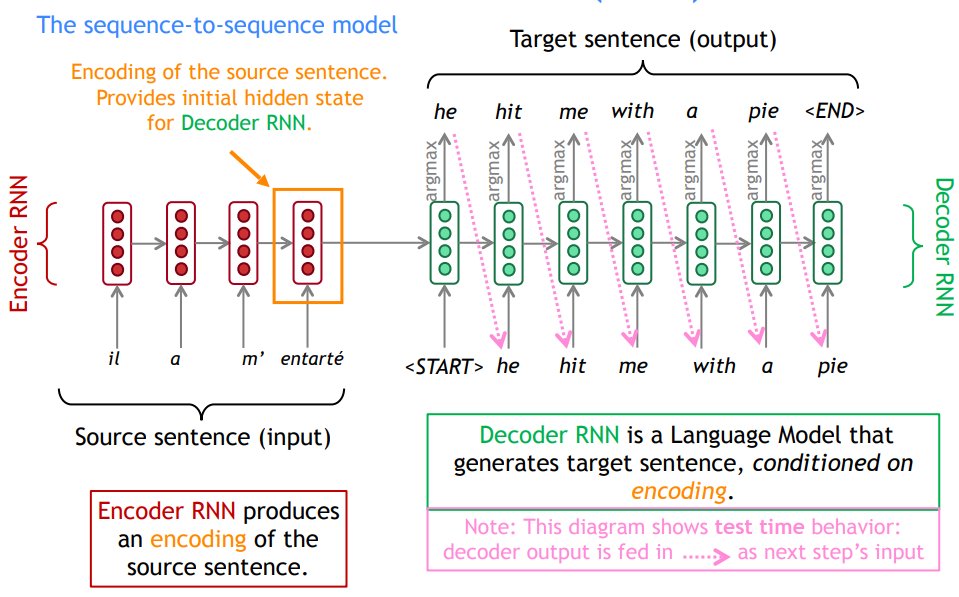

## Encoder

The part of model map the source sequence to hidden vector (encoding).

In [13]:
class Encoder(nn.Module):

    def __init__(self, embed_size, vocab_size, hidden_size,
                 n_layers=1, dropout=0, bidirectional=True):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embed_size, hidden_size,
                            num_layers=n_layers,
                            dropout=(dropout if n_layers > 1 else 0),
                            bidirectional=bidirectional)
    
    def forward(self, in_, seq_len):
        """
        inputs
            in_: (seq_len, batch_size)
            seq_len: (batch_size)

        outputs
            out: (seq_len, batch_size, num_directions * hidden_size)
            hn: (num_layers * num_directions, batch_size, hidden_size)
            cn: (num_layers * num_directions, batch_size, hidden_size)
        """
        embedded = self.embedding(in_)
        embedded = self.dropout(embedded)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, seq_len)
        out, (hn, cn) = self.lstm(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(out)
        return out, hn, cn

## Decoder

The part of model performs a conditional language modeling given the hidden vector outputs by the encoder.

In [14]:
class Decoder(nn.Module):

    def __init__(self, embed_size, vocab_size, hidden_size,
                 n_layers=1, dropout=0):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embed_size, hidden_size,
                            num_layers=n_layers,
                            dropout=(dropout if n_layers > 1 else 0))
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, in_, h0, c0):
        """
        inputs
            in_: (1, batch_size) => seq_len = 1, a word
            h0: (num_layers, batch_size, hidden_size)
            c0: (num_layers, batch_size, hidden_size)

        embed = self.embedding(_in) 
        # embedded: (1, batch_size, embed_size)
        out, hn, cn = self.lstm(embedded)
        # out: (1, batch_size, hidden_size)
        # hn: (num_layers, batch_size, hidden_size)
        # cn: (num_layers, batch_size, hidden_size)
        logit = self.fc(out.squeeze(0))
        # logit: (batch_size, vocab_size)

        outputs: logit, hn, cn
        """
        embedded = self.embedding(in_)
        embedded = self.dropout(embedded)
        out, (hn, cn) = self.lstm(embedded, (h0, c0))
        logit = self.fc(out.squeeze(0))
        return logit, hn, cn

## Sequence to sequence model

This puts encoder and decoder together.

In [15]:
class SeqToSeqNet(nn.Module):

    def __init__(self, encoder, decoder, device=device):
        assert encoder.n_layers == decoder.n_layers, \
        'Encoder and Decoder have to have the same number of reccurent layers'
        assert encoder.hidden_size == decoder.hidden_size, \
        'Encoder and Decoder have to have the same number of reccurent hidden units'

        super(SeqToSeqNet, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def encode(self, in_, seq_len):
        _, hn, cn = self.encoder(in_, seq_len)
        # Sum the two directional encoder hn state
        if self.encoder.bidirectional:
            hn = hn[:self.encoder.n_layers, :, :] + \
                    hn[self.encoder.n_layers:, :, :]
            cn = cn[:self.encoder.n_layers, :, :] + \
                    cn[self.encoder.n_layers:, :, :]
        return hn, cn

    def decode(self, h_state, c_state, target, sos_index, teacher_forcing, ratio):
        target_len, batch_size = target.size()
        out = torch.zeros((target_len, batch_size, self.decoder.vocab_size),
                           device=self.device)
        in_ = target[0, :].unsqueeze(0)
        for t in range(1, target_len):
            logit, h_state, c_state = self.decoder(in_, h_state, c_state)
            out[t] = logit # (batch_size, vocab_size)
            if teacher_forcing and random.random() < ratio:
                in_ = logit.argmax(1).unsqueeze(0) # (1, batch_size)
            else:
                in_ = target[t, :].unsqueeze(0)
        return out
    
    def forward(self, in_, seq_len, target, sos_index,
                teacher_forcing=True, ratio=.5):
        """
        inputs
            in_: (seq_len, batch_size)
            seq_len: (batch_size)
            target: (seq_len, batch_size)
            sos_index: int
            eos_index: int

        outputs
            out: (seq_len, batch_size, vocab_size)
        """
        hn, cn = self.encode(in_, seq_len)
        out = self.decode(hn, cn, target, sos_index, teacher_forcing, ratio)
        return out

## Training

In [16]:
def init_weights(model):
    # for name, param in model.named_parameters():
        # nn.init.uniform_(param.data, a=-0.08, b=0.08)
    if hasattr(model, 'weight') and model.weight.dim() > 1:
        nn.init.xavier_uniform_(model.weight.data)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [17]:
def plot_grad_flow(named_parameters):
    grad_mean, layers = [], []
    for name, param in named_parameters:
        if param.requires_grad and 'bias' not in name:
            layers.append(name)
            grad_mean.append(param.grad.abs().mean())
    plt.plot(grad_mean, alpha=0.3, color='b')
    plt.hlines(0, 0, len(grad_mean) + 1, linewidth=1, color='k' )
    plt.xticks(range(0, len(grad_mean), 1), layers, rotation='vertical')
    plt.xlim(xmin=0, xmax=len(grad_mean))
    # plt.ylim(bottom=-0.001, top=0.02) # Zoom on lower gradients
    plt.xlabel('Layers')
    plt.ylabel('Mean of gradients')
    plt.title('Gradient Flow')
    plt.grid(True)

In [18]:
def train_step(model, opt, loss_func, data_it, grad_clip, sos_index,
               epoch_text=''):
    epoch_loss = 0.
    pbar = tqdm.tqdm(enumerate(data_it), total=len(data_it))
    model.train()
    for i, data in pbar:
        opt.zero_grad()
        logits = model(*data.src, data.dest, sos_index)
        # *data.src: unpack in_ and seq_len
        loss = loss_func(logits[1:].view(-1, logits.size(-1)),
                         data.dest[1:].view(-1))
        loss.backward()
        # plot_grad_flow(model.named_parameters())
        if grad_clip:
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        opt.step()
        epoch_loss += loss.item()
        pbar.set_description(epoch_text + f'Train Loss: {epoch_loss/(i+1):.3f}')
    # plt.show() # Show the gradient flow
    return epoch_loss / len(data_it)

In [19]:
def valid_step(model, loss_func, data_it, sos_index, epoch_text=''):
    epoch_loss = 0.
    pbar = tqdm.tqdm(enumerate(data_it), total=len(data_it))
    model.eval()
    with torch.no_grad():
        for i, data in pbar:
            logits = model(*data.src, data.dest, sos_index,
                           teacher_forcing=False)
            loss = loss_func(logits[1:].view(-1, logits.size(-1)),
                             data.dest[1:].view(-1))
            epoch_loss += loss.item()
            pbar.set_description(epoch_text + f'Valid Loss: {epoch_loss/(i+1):.3f}')
    return epoch_loss / len(data_it)


In [20]:
def train(model, optimizer, scheduler, loss_function, train_it, valid_it, n_epochs, sos_index,
          grad_clip=None, save_to='./saved_models', filename='seq2seq-baseline.pt'):
    assert callable(loss_function)
    if not os.path.exists(save_to):
        !mkdir {save_to}

    history = {'loss': [], 'val_loss': []}
    best_loss = float('inf')
    for epoch in range(n_epochs):
        epoch_text = f'Epoch: {epoch + 1:02d} - '
        loss = train_step(model, optimizer, loss_function, train_it, grad_clip,
                          sos_index, epoch_text)
        val_loss = valid_step(model, loss_function, valid_it, sos_index,
                              epoch_text)

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save({'model': model.state_dict(),
                        'optimizer': optimizer.state_dict()},
                       f=os.path.join(save_to, filename))
            
        scheduler.step(val_loss) # Update the learning rate if no improvement

        history['loss'].append(loss)
        history['val_loss'].append(val_loss)

    return history

In [21]:
EMBEDDING_DIM = 300
HIDDEN_SIZE = 512
N_LAYERS = 2
DROPOUT = 0.5
LR = 1e-3
GRAD_CLIP = 1.0
BATCH_SIZE = 128
N_EPOCHS = 30
MAX_LEN = 50

In [22]:
train_iterator, valid_iterator, test_iterator =  \
        BucketIterator.splits((train_data, valid_data,
                               test_data),
                              batch_size=BATCH_SIZE,
                              sort_key=lambda x: len(x.src),
                              sort_within_batch=True, # For pack_padded_sequence
                              device=device)

In [23]:
encoder = Encoder(embed_size=EMBEDDING_DIM,
                  vocab_size=len(FR.vocab),
                  hidden_size=HIDDEN_SIZE,
                  n_layers=N_LAYERS,
                  dropout=DROPOUT).to(device)
decoder = Decoder(embed_size=EMBEDDING_DIM,
                  vocab_size=len(EN.vocab),
                  hidden_size=HIDDEN_SIZE,
                  n_layers=N_LAYERS,
                  dropout=DROPOUT).to(device)
seq2seq = SeqToSeqNet(encoder=encoder, decoder=decoder).to(device)
seq2seq.apply(init_weights)
optimizer = optim.Adam(seq2seq.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, factor=0.5, min_lr=3e-5)
criterion = nn.CrossEntropyLoss(ignore_index=EN.vocab.stoi[EN.pad_token])
print(f'Number of parameters of the model: {count_parameters(seq2seq):,}')

Number of parameters of the model: 27,103,199


In [24]:
%%time
history = train(seq2seq, optimizer, scheduler, criterion,
                train_iterator, valid_iterator,
                sos_index=EN.vocab.stoi[EN.init_token],
                n_epochs=N_EPOCHS, grad_clip=GRAD_CLIP)

Epoch: 30 - Valid Loss: 4.100: 100%|██████████| 12/12 [00:00<00:00, 15.27it/s]

CPU times: user 29min 32s, sys: 9min 7s, total: 38min 40s
Wall time: 38min 56s


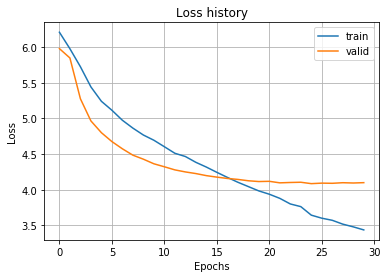

In [30]:
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='valid')
plt.title('Loss history')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
seq2seq.load_state_dict(torch.load('./saved_models/seq2seq-baseline.pt').get('model'))
test_loss = valid_step(seq2seq, criterion, test_iterator,
                       sos_index=EN.vocab.stoi[EN.init_token],
                       epoch_text='Test loss => ')
print()
print(f'Test Loss={test_loss:.3f}, Perplexity={np.exp(test_loss):.3f}')

Test loss => Valid Loss: 4.115: 100%|██████████| 12/12 [00:00<00:00, 13.43it/s]


Test Loss=4.115, Perplexity=61.255


# Perplexity, Inference & BLEU Score

We two metrics to evaluate the model:

- **Extrinsic evalution:** evaluates the quality of the downstream task (Machine Translation). We used **BLEU Score** as main metrics.

$$ BLEU =  $$

- **Intrinsic evalution:** evaluates the quality the language model itself (decoder). We user **Perplexity**

$$ Perplexity = \prod_{t=1}^T (\frac{1}{P_{LM}(x_{t+1}|x_{t}, ..., x_{1})})^{\frac{1}{T}} $$

For inference, we can use three different algorithms:

- **Greedy decoding:** it's a simple and intuitive method. It gives low quality output.
- **Sampling method:** it's  a way to get more diversity and randomness. We can also apply temperature in order to control diversity
- **Beam search:** searches for high probability output. Delivers better quality than greedy, but if beam size is too high, can return high-probability but unsuitable output (e.g. generic, short)

In [25]:
class InferenceAlgo:
    """
    Inference algorithms
    """
    GREEDY = 'GREEDY'
    SAMPLING = 'SAMPLING'
    BEAM_SEARCH = 'BEAM_SEARCH'

In [26]:
class BeamNode:
    __index = 0

    def __init__(self, token, h_state, c_state, logp, path_logp, step, parent):
        self.token = token
        self.h_state = h_state
        self.c_state = c_state
        self.logp = logp
        self.path_logp = path_logp
        self.step = step
        self.index = self.__class__.__index
        self.parent = parent

        self.__class__.__index += 1

In [40]:
class BeamSearch:

    def __init__(self, decoder, h_state, c_state, sos_token, eos_token, beam_size, device=device):
        self.decoder = decoder
        self.sos_token = sos_token
        self.eos_token = eos_token
        self.beam_size = beam_size
        self.device = device

        self.tree = []
        self.step = 0
        self.terminal = False

        root = BeamNode(token=sos_token, h_state=h_state, c_state=c_state,
                        logp=0., path_logp=0., step=0, parent=None)
        self.tree.append([root])

    def one_step(self):
        self.step += 1
        children = []
        for node in self.tree[-1]:
            if node.token == self.eos_token:
                continue

            in_ = torch.tensor([[node.token]], device=self.device)
            logit, h_state, c_state = self.decoder(in_, node.h_state, node.c_state)
            logps = F.softmax(logit, dim=1).squeeze(0).cpu().numpy()
            logps = np.log(logps)
            
            path_logps = logps + node.path_logp
            topk_tokens = np.argsort(path_logps)[::-1][:self.beam_size]

            for token in topk_tokens:
                child = BeamNode(token=token, h_state=h_state, c_state=c_state,
                                 logp=logps[token], path_logp=path_logps[token],
                                 step=self.step, parent=node.index)
                children.append(child)
        self.tree.append(children)
        
        if len(children) == 0:
            self.terminal = True
        
    def prune(self):
        if self.terminal:
            self.tree = self.tree[:-1]
        else:
            self.tree[-1].sort(key=lambda node: node.path_logp, reverse=True)
            self.tree[-1] = self.tree[-1][:self.beam_size]

    def get_path(self):
        current_node = max(self.tree[-1], key=lambda node: node.path_logp)
        parent = current_node.parent
        nodes = [current_node]
        while parent is not None:
            for node in self.tree[current_node.step - 1]:
                if node.index == parent:
                    nodes.append(node)
                    current_node = node
                    parent = node.parent
                    break
        return nodes[::-1]

In [41]:
class Inference:
    
    def __init__(self, model, src_field, dest_field, device=device):
        self.model = model
        self.src_field = src_field
        self.dest_field = dest_field
        self.device = device
        
    def greedy_search(self, h_state, c_state, max_len):
        translated_sequence = []
        sos_token = self.dest_field.vocab.stoi[self.dest_field.init_token]
        eos_token = self.dest_field.vocab.stoi[self.dest_field.eos_token]
        in_ = torch.tensor([[sos_token]], device=self.device)
        for t in range(max_len):
            logit, h_state, c_state = self.model.decoder(in_, h_state, c_state)
            probs = F.softmax(logit, dim=1) # (1, vocab_size)
            token = torch.multinomial(probs, 1).squeeze().cpu().item() # (1, 1)
            if token == eos_token:
                break
            translated_sequence.append(token)
            in_ = torch.tensor([[token]], device=self.device)
        return translated_sequence
    
    def sampling(self, h_state, c_state, max_len):
        translated_sequence = []
        sos_token = self.dest_field.vocab.stoi[self.dest_field.init_token]
        eos_token = self.dest_field.vocab.stoi[self.dest_field.eos_token]
        in_ = torch.tensor([[sos_token]], device=self.device)
        for t in range(max_len):
            logit, h_state, c_state = self.model.decoder(in_, h_state, c_state)
            token = logit.argmax(1).cpu().item()
            if token == eos_token:
                break
            translated_sequence.append(token)
            in_ = torch.tensor([[token]], device=self.device)
        return translated_sequence
    
    def beam_search(self, h_state, c_state, max_len, beam_size):
        sos_token = self.dest_field.vocab.stoi[self.dest_field.init_token]
        eos_token = self.dest_field.vocab.stoi[self.dest_field.eos_token]
        beamsearch = BeamSearch(self.model.decoder, h_state, c_state, sos_token, eos_token, beam_size, self.device)
        i = 0
        while i < max_len - 1:
            beamsearch.one_step()
            beamsearch.prune()
            i += 1
            if beamsearch.terminal:
                break
        nodes = beamsearch.get_path()
        translated_sequence = [*map(lambda node: node.token, nodes)]
        translated_sequence = [token for token in translated_sequence
                               if token != sos_token and token != eos_token]
        return translated_sequence
    
    def translate(self, sentences, max_len, algo, preprocess, beam_size=None):
        if preprocess: # To split and reverse sentences
            sentences = [*map(self.src_field.preprocess, sentences)]
        sentences, seq_lens = self.src_field.process(sentences)
        
        translated_sequences = []
        pbar = tqdm.tqdm([*zip(sentences.t(), seq_lens)])
        self.model.eval()
        with torch.no_grad():
            for data in pbar:
                sequence, seq_len = data
                h_state, c_state = self.model.encode(sequence.unsqueeze(1).to(self.device),
                                                     seq_len.unsqueeze(0))
                if algo == InferenceAlgo.GREEDY:
                    translated_sequence = self.greedy_search(h_state, c_state, max_len)
                elif algo == InferenceAlgo.SAMPLING:
                    translated_sequence = self.sampling(h_state, c_state, max_len)
                elif algo == InferenceAlgo.BEAM_SEARCH:
                    translated_sequence = self.beam_search(h_state, c_state, max_len, beam_size)
                else:
                    raise ValueError('Not implemented inference algo!')
                    
                translated_sequences.append(translated_sequence)
        translated_sentences = [[*map(self.dest_field.vocab.itos.__getitem__, translated_sequence)]
                                for translated_sequence in translated_sequences]
        return translated_sentences

In [42]:
# fr_sentences = [pairs[5]['fr'], pairs[9]['fr']]
# en_sentences = [pairs[5]['en'], pairs[9]['en']]

fr_sentences = [test_data.examples[i].src for i in range(len(test_data.examples))]
en_sentences = [test_data.examples[i].dest for i in range(len(test_data.examples))]

inference = Inference(seq2seq, FR, EN)

In [33]:
# Greedy search inference
translations = inference.translate(fr_sentences, MAX_LEN, InferenceAlgo.GREEDY, False)
bleu = bleu_score(translations, [*map(lambda x: [x], en_sentences)])
translations = [*map(lambda sentence: ' '.join(sentence), translations)]

indexes = np.random.choice(len(test_data.examples), 5)
for i in indexes:
    print('FR: \t\t\t', ' '.join(fr_sentences[i][::-1]))
    print('-'*100)
    print('EN: \t\t\t', ' '.join(en_sentences[i]))
    print(f'EN Translation: \t', translations[i])
    print('#'*100)
print('='*100)
print('='*40 + f' BLEU score: {bleu*100:.2f} % ' + '='*40)
print('='*100)

100%|██████████| 1500/1500 [00:26<00:00, 55.81it/s]


FR: 			 permettez - moi de vous rappeler une partie de l’ article 25 de la declaration universelle des droits de l’ homme : « toute personne a droit a un niveau de vie suffisant pour assurer sa sante , son bien-etre et ceux de sa famille , notamment pour l’ alimentation , l’ habillement , le logement , les soins medicaux … » .
----------------------------------------------------------------------------------------------------
EN: 			 allow me to remind you of part of article 25 of the universal declaration of human rights : ‘ everyone has the right to a standard of living adequate for the health and well - being of himself and of his family , including food , clothing , housing and medical care … ’
EN Translation: 	 i should like to take an proverb reference to revision of the court on immigration energy set in this sphere of and major aid to the food forms of property or the , proposed , sexual immigration ; while eu product is exploiting to the i could not produce this
##############

In [34]:
# Inference with sampling
translations = inference.translate(fr_sentences, MAX_LEN, InferenceAlgo.SAMPLING, False)
bleu = bleu_score(translations, [*map(lambda x: [x], en_sentences)])
translations = [*map(lambda sentence: ' '.join(sentence), translations)]

for i in indexes:
    print('FR: \t\t\t', ' '.join(fr_sentences[i][::-1]))
    print('-'*100)
    print('EN: \t\t\t', ' '.join(en_sentences[i]))
    print(f'EN Translation: \t', translations[i])
    print('#'*100)
print('='*100)
print('='*40 + f' BLEU score: {bleu*100:.2f} % ' + '='*40)
print('='*100)

100%|██████████| 1500/1500 [00:31<00:00, 46.99it/s]


FR: 			 permettez - moi de vous rappeler une partie de l’ article 25 de la declaration universelle des droits de l’ homme : « toute personne a droit a un niveau de vie suffisant pour assurer sa sante , son bien-etre et ceux de sa famille , notamment pour l’ alimentation , l’ habillement , le logement , les soins medicaux … » .
----------------------------------------------------------------------------------------------------
EN: 			 allow me to remind you of part of article 25 of the universal declaration of human rights : ‘ everyone has the right to a standard of living adequate for the health and well - being of himself and of his family , including food , clothing , housing and medical care … ’
EN Translation: 	 let me remind you to to a a a the the of the european of the ( the ) , the , the the of the to the to the to the to the , of the , and , , and the , of the , , , ,
####################################################################################################
FR: 			 d

In [44]:
# Inference with Beam search
translations = inference.translate(fr_sentences, MAX_LEN, InferenceAlgo.BEAM_SEARCH, False, beam_size=2)
bleu = bleu_score(translations, [*map(lambda x: [x], en_sentences)])
translations = [*map(lambda sentence: ' '.join(sentence), translations)]

for i in indexes:
    print('FR: \t\t\t', ' '.join(fr_sentences[i][::-1]))
    print('-'*100)
    print('EN: \t\t\t', ' '.join(en_sentences[i]))
    print(f'EN Translation: \t', translations[i])
    print('#'*100)
print('='*100)
print('='*40 + f' BLEU score: {bleu*100:.2f} % ' + '='*40)
print('='*100)

100%|██████████| 1500/1500 [02:33<00:00,  9.76it/s]


FR: 			 permettez - moi de vous rappeler une partie de l’ article 25 de la declaration universelle des droits de l’ homme : « toute personne a droit a un niveau de vie suffisant pour assurer sa sante , son bien-etre et ceux de sa famille , notamment pour l’ alimentation , l’ habillement , le logement , les soins medicaux … » .
----------------------------------------------------------------------------------------------------
EN: 			 allow me to remind you of part of article 25 of the universal declaration of human rights : ‘ everyone has the right to a standard of living adequate for the health and well - being of himself and of his family , including food , clothing , housing and medical care … ’
EN Translation: 	 let me remind you to mention a a of of the committee on the affairs ( <unk> ) , the is a to to the the of of of the , and , , , , to the the of the , , and the , of the ,
####################################################################################################
FR